In [1]:
import time
notebook_start_time = time.time()

- the Llama 2 paper: [Llama 2: Open Foundation and Fine-Tuned Chat Models (2023)](https://arxiv.org/abs/2307.09288)

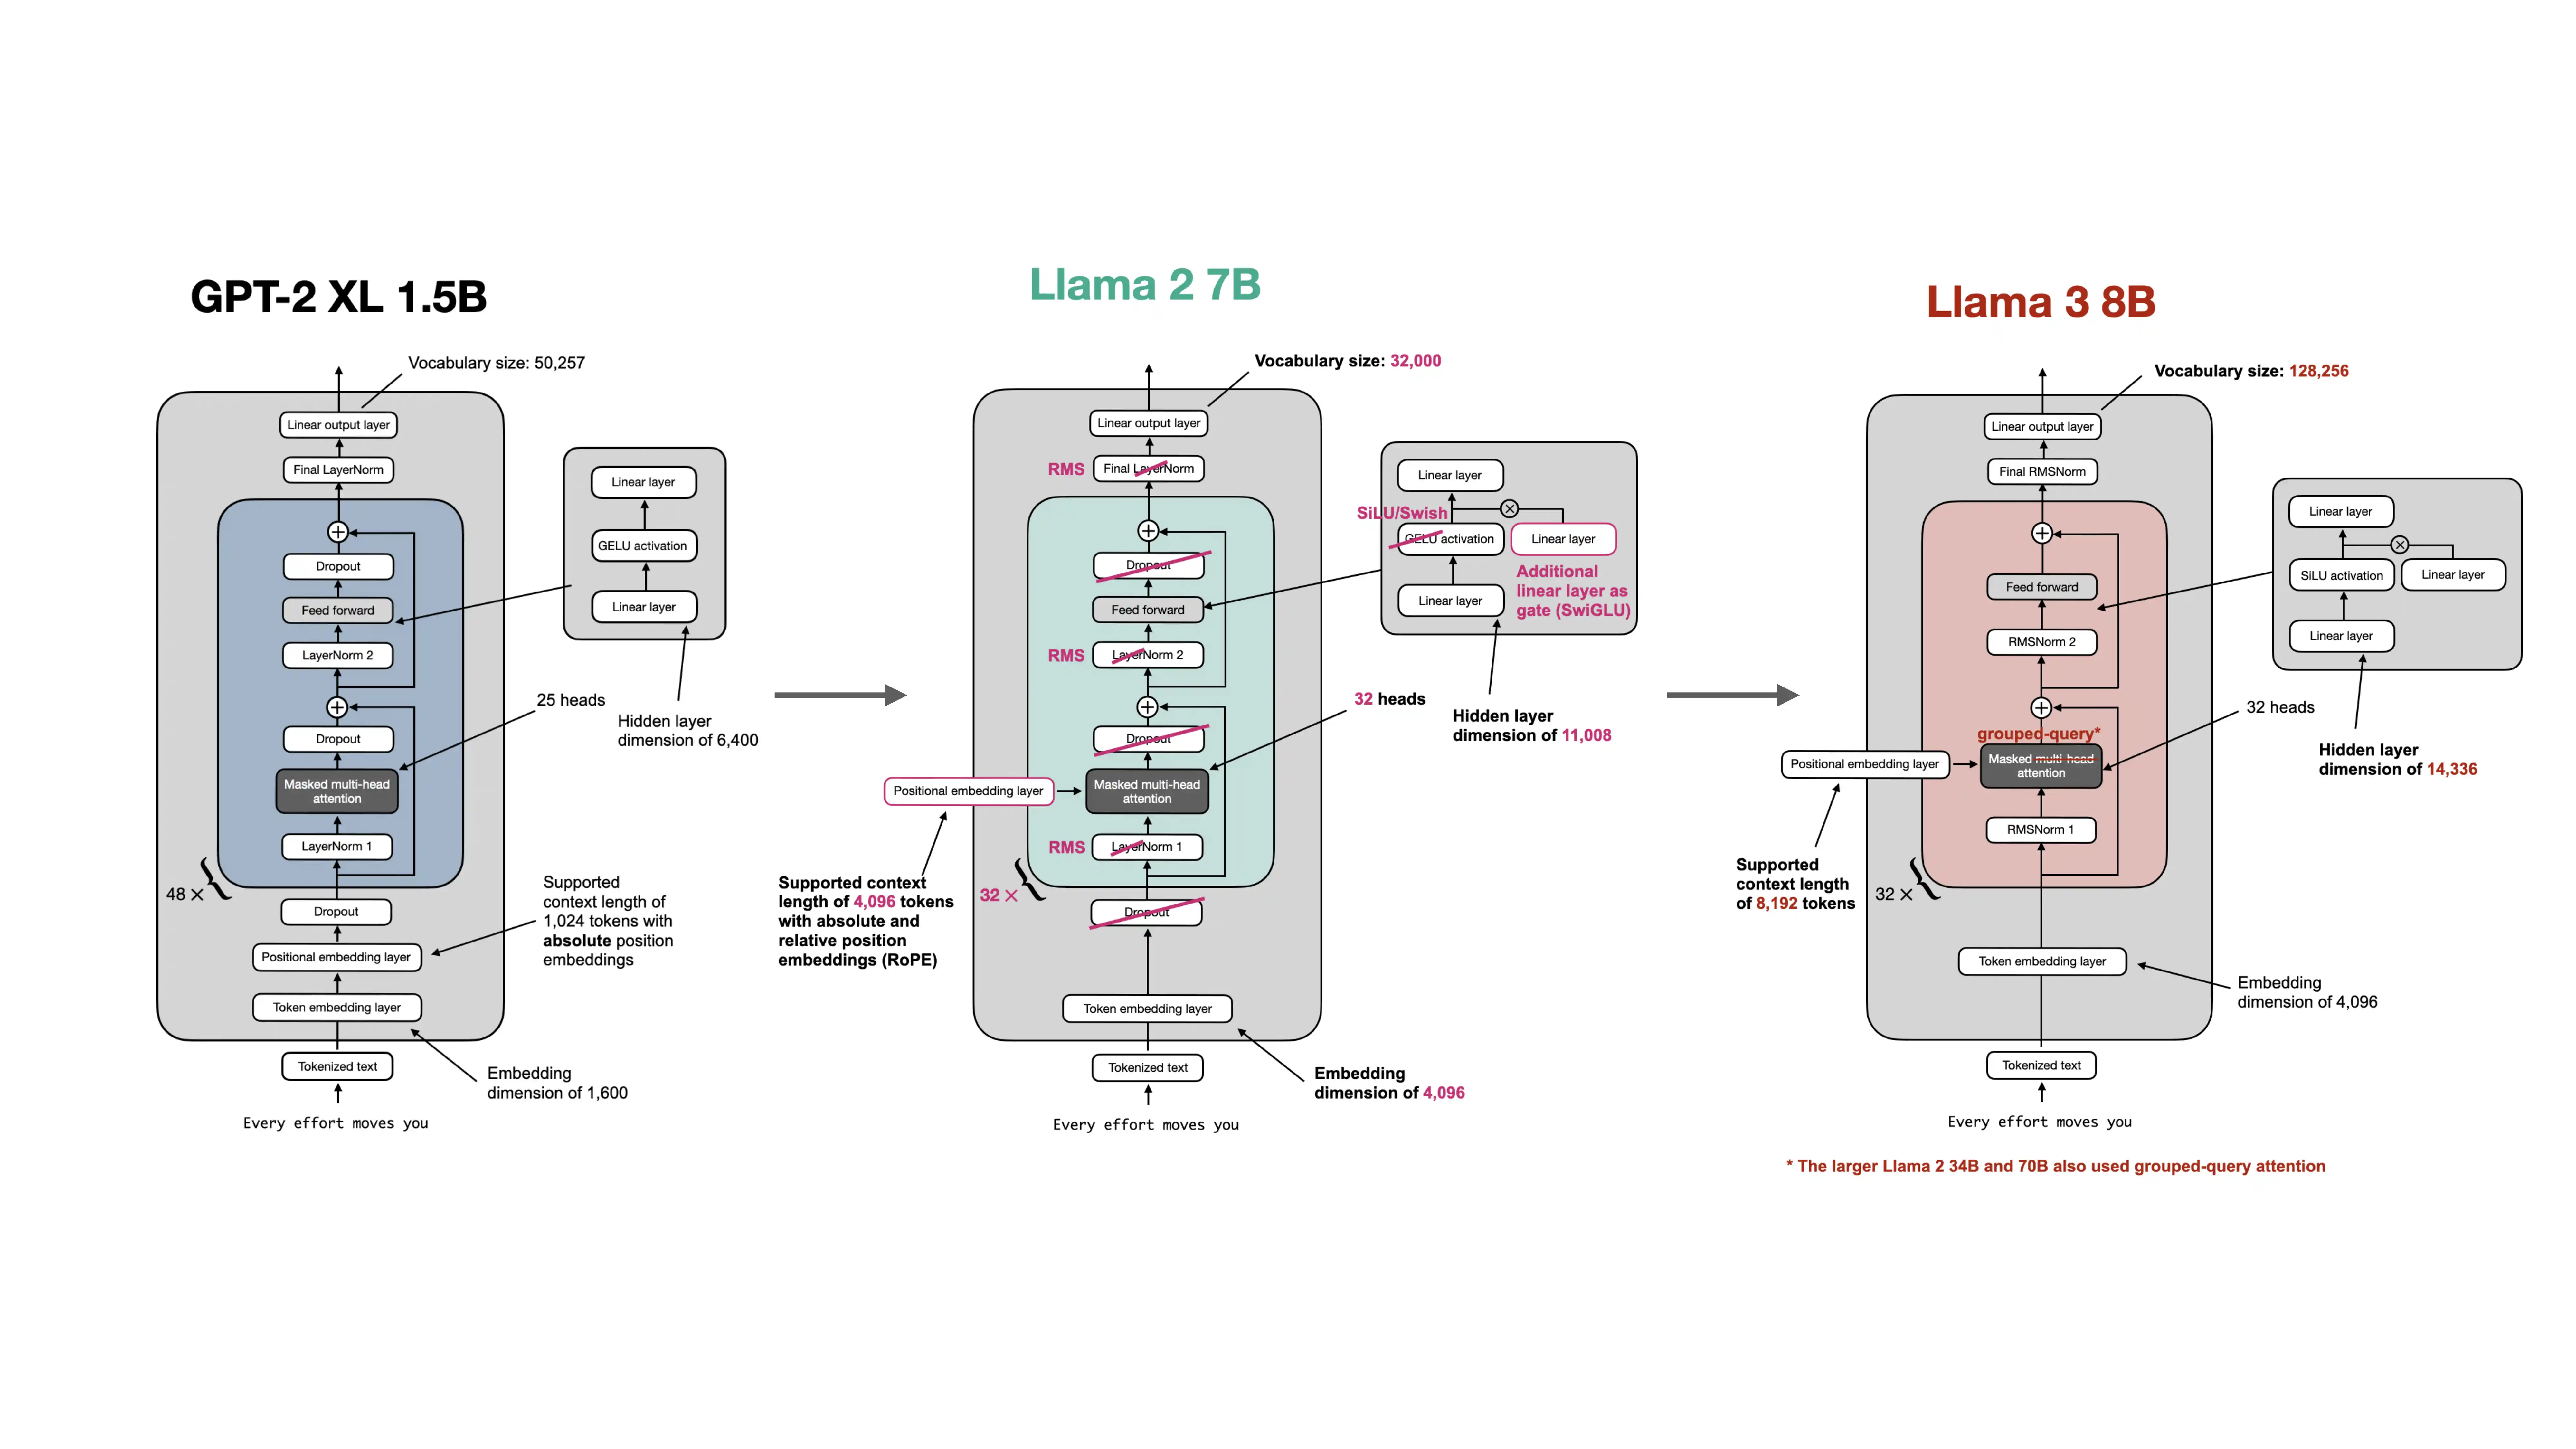


# 0. Setup

In [2]:
# from google.colab import files
# uploaded = files.upload()

In [3]:
from importlib.metadata import version

pkgs = [
    "huggingface_hub",  # to download pretrained weights
    "sentencepiece",    # to implement the tokenizer
    "torch",            # to implement the model
]
for p in pkgs:
    print(f"{p} version: {version(p)}")

huggingface_hub version: 0.33.0
sentencepiece version: 0.2.0
torch version: 2.6.0+cu124


# 1. Convert the GPT model implementation step by step

- We will modify the `GPT2Model` to implement step-by-step the `Llama 2 architecture`
- then we load the original Llama 2 weights shared by Meta AI

## 1.1 Replace "LayerNorm" with "Root Mean Square Layer Normalization (RMSNorm)" layer

- LayerNorm normalizes inputs using mean and variance, while RMSNorm uses only the root mean square, which improves computational efficiency:

$$
\boxed{
y_i = \frac{x_i}{\text{RMS}(x)}\gamma_i \;, \qquad \text{where} \qquad \text{RMS}(x) = \sqrt{\epsilon + \frac{1}{n}\sum x_i^2}
}
$$
, where:
  - $\mathbf{\gamma}$: trainable parameter

- the paper: [Root Mean Square Layer Normalization (2019)](https://arxiv.org/abs/1910.07467)

In [4]:
import torch

x = torch.tensor([[ 1.0, 2.0,  3.0],
                  [ 4.0,  4.0, 4.0]])


squared = x.pow(2)
print("squared:", squared)


means = squared.mean(dim=-1, keepdim=True)
print("means:", means)

squared: tensor([[ 1.,  4.,  9.],
        [16., 16., 16.]])
means: tensor([[ 4.6667],
        [16.0000]])


In [5]:
import torch
import torch.nn as nn


#####################################
# Chapter 4
#####################################

# class LayerNorm(nn.Module):
#     def __init__(self, emb_dim):
#         super().__init__()
#         self.epsilon = 1e-5
#         self.scale = nn.Parameter(torch.ones(emb_dim))
#         self.shift = nn.Parameter(torch.zeros(emb_dim))

#     def forward(self, x):
#         mean = x.mean(dim=-1, keepdim=True)
#         var = x.var(dim=-1,
#                     unbiased=False,  # Bessel's correction (n-1)
#                     keepdim=True)
#         norm_x = (x - mean) / torch.sqrt(var + self.epsilon)
#         return self.scale * norm_x + self.shift


class RMSNorm(nn.Module):
  def __init__(self, emb_dim, eps=1e-5):
    super().__init__()
    self.eps = eps
    self.emb_dim = emb_dim
    self.weight = nn.Parameter(torch.ones(emb_dim)).float()

  def forward(self, x):
    means = x.pow(2).mean(dim=-1, keepdim=True)
    x_normed = (x *
                torch.rsqrt(means + self.eps) # reciprocal of the square root
                )
    return (x_normed * self.weight).to(dtype=x.dtype)


- let's check that this implementation works the same as PyTorch's built-in implementation:

In [6]:
torch.manual_seed(211)

example_batch = torch.randn(2, 3, 4)

# our implementation
rms_norm = RMSNorm(emb_dim=example_batch.shape[-1])
print(rms_norm(example_batch))


# Pytorch built-in implementation
rmsnorm_pytorch = torch.nn.RMSNorm(example_batch.shape[-1], eps=1e-5)
print(rmsnorm_pytorch(example_batch))

assert torch.allclose(rms_norm(example_batch),
                      rmsnorm_pytorch(example_batch))

tensor([[[ 0.2605, -1.5791, -1.1896, -0.1524],
         [ 1.1488,  0.3680, -1.2832, -0.9473],
         [ 1.8431,  0.4302, -0.0954, -0.6392]],

        [[ 0.1374,  1.0788, -1.5436,  0.6592],
         [-0.2851, -0.0955, -0.2852, -1.9566],
         [ 1.6664,  0.4131,  0.6329, -0.8074]]], grad_fn=<MulBackward0>)
tensor([[[ 0.2605, -1.5791, -1.1896, -0.1524],
         [ 1.1488,  0.3680, -1.2832, -0.9473],
         [ 1.8431,  0.4302, -0.0954, -0.6392]],

        [[ 0.1374,  1.0788, -1.5436,  0.6592],
         [-0.2851, -0.0955, -0.2852, -1.9566],
         [ 1.6664,  0.4131,  0.6329, -0.8074]]], grad_fn=<MulBackward0>)


## 1.2 Replace GELU with SiLU activation

- Llama uses the SiLU (or Swish) activation function:

$$
\boxed{
\text{silu}(x) = x \cdot \sigma(x), \qquad \text{where} \qquad \sigma(x) \text{ is the logistic sigmoid}
}
$$

- the SiLU paper: [Sigmoid-Weighted Linear Units for Neural Network Function Approximation in Reinforcement Learning (2017)](https://arxiv.org/abs/1702.03118)

In [7]:
#####################################
# Chapter 4
#####################################

# class GELU(nn.Module):
#     def __init__(self):
#         super().__init__()

#     def forward(self, x):
#         return 0.5 * x * (1 + torch.tanh(
#             torch.sqrt(torch.tensor(2.0 / torch.pi)) *
#             (x + 0.044715 * torch.pow(x, 3))
#         ))


class SiLU(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, x):
    return x * torch.sigmoid(x)

In [8]:
silu = SiLU()

assert torch.allclose(silu(example_batch),
                      torch.nn.functional.silu(example_batch))

## 1.3 Update the FeedForward module

- Llama uses a `Gates Linear Unit (GLU)` variant of `SiLU` called `SwiGLU` in the FeedForward module. `SwiGLU` uses a gating mechanism:
$$
\boxed{
\begin{align}
\text{SwiGLU}(x) &= \text{SiLU}(\text{Linear}_1(x)) \ast \text{Linear}_2(x) \\
y &= \text{Linear}_3(x)
\end{align}
}
$$
, where
   - $\ast$: element-wise multiplication

- SwiGLU paper: [GLU Variants Improve Transformer (2020)](https://arxiv.org/abs/2002.05202)

In [9]:
#####################################
# Chapter 4
#####################################
# class FeedForward(nn.Module):
#     def __init__(self, config):
#         super().__init__()
#         self.layers = nn.Sequential(
#             nn.Linear(config["emb_dim"],  # 768
#                       4 * config["emb_dim"]),  # 3072
#             GELU(),  # 3072
#             nn.Linear(4 * config["emb_dim"],  # 3072
#                       config["emb_dim"])  # 768
#         )

#     def forward(self, x):
#         return self.layers(x)


class FeedForward(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.silu = SiLU()
    self.fc1 = nn.Linear(config["emb_dim"],
                         config["hidden_dim"],
                         dtype=config["dtype"],
                         bias=False)
    self.fc2 = nn.Linear(config["emb_dim"],
                         config["hidden_dim"],
                         dtype=config["dtype"],
                         bias=False)
    self.fc3 = nn.Linear(config["hidden_dim"],
                         config["emb_dim"],
                         dtype=config["dtype"],
                         bias=False)

  def forward(self, x):
    x_fc1 = self.fc1(x)
    x_silu = self.silu(x_fc1)
    x_fc2 = self.fc2(x)
    x_swiglu = x_silu * x_fc2
    return self.fc3(x_swiglu)

## 1.4 Implement Rotary Position Embeddings (RoPE)

- recall the GPT2's positional embeddings implementation:
```python
self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
```
- Llama uses RoPE, which enables it to capture both absolute and relative positional information simultaneously
- RoPE paper: [RoFormer: Enhanced Transformer with Rotary Position Embedding (2021)](https://arxiv.org/abs/2104.09864)

- Why only inject RoPE for Q & K, but not V?
  - Because RoPE’s job is to inject position into the attention weights, not into the information that ultimately flows forward.
  - It needs to touch the vectors that form the dot-products ( Q · K)^⊤—that is, queries and keys—so the soft-max can see position.
  - Values are only looked up after those weights are decided; keeping them un-rotated lets the network pass “pure content” downstream.

In [10]:
def precompute_rope_params(head_dim,
                           theta_base=10_000,
                           context_length=4096):
  assert head_dim % 2 == 0, "Embedding dimension must be even"

  # (Eq. 1) compute the inverse frequencies
  # theta_i = 10000 ^ (-2(i-1)/dim) for i = 1, 2, ..., dim/2
  inv_freq = 1.0 / (
      theta_base ** (torch.arange(0, head_dim, 2).float() / head_dim))

  # generate position indices
  positions = torch.arange(context_length)

  # compute the angles
  # positions -> row vector
  # inv_freq -> column vector
  angles = positions[:, None] * inv_freq[None, :] # (context_length, head_dim // 2)

  # expand angles to match the head_dim
  angles = torch.cat([angles, angles], dim=1) # (context_length, head_dim)

  # precompute sine and cosine
  cos = torch.cos(angles)
  sin = torch.sin(angles)

  return cos, sin


def compute_rope(x, cos, sin):
  # x -> (batch_size, num_heads, seq_len, head_dim)
  batch_size, num_heads, seq_len, head_dim = x.shape
  assert head_dim % 2 == 0, "Embedding dimension must be even"

  # split x into two subspaces
  x1 = x[..., :head_dim // 2] # first half
  x2 = x[..., head_dim // 2 :] # second half

  # adjust sin and cos shapes
  cos = cos[:seq_len, :].unsqueeze(0).unsqueeze(0)  # Shape: (1, 1, seq_len, head_dim)
  sin = sin[:seq_len, :].unsqueeze(0).unsqueeze(0)

  # apply the rotary transformation
  rotated = torch.cat((-x2, x1), dim=-1)
  x_rotated = (x * cos) + (rotated * sin)

  return x_rotated.to(dtype=x.dtype)

- Let's apply on an example:

In [11]:
batch_size = 2
context_len = 3
num_heads = 4
head_dim = 4

# instantiate RoPE parameters
cos, sin = precompute_rope_params(head_dim=head_dim,
                                  context_length=context_len)
cos.shape, sin.shape, cos

(torch.Size([3, 4]),
 torch.Size([3, 4]),
 tensor([[ 1.0000,  1.0000,  1.0000,  1.0000],
         [ 0.5403,  0.9999,  0.5403,  0.9999],
         [-0.4161,  0.9998, -0.4161,  0.9998]]))

In [12]:
# dummy query and key tensors
torch.manual_seed(211)
queries = torch.randn(batch_size,
                      num_heads,
                      context_len,
                      head_dim)
keys = torch.randn(batch_size,
                   num_heads,
                   context_len,
                   head_dim)

queries.shape, queries

(torch.Size([2, 4, 3, 4]),
 tensor([[[[ 0.1966, -1.1918, -0.8979, -0.1151],
           [ 0.2576,  0.0825, -0.2878, -0.2125],
           [-0.1507,  0.4813,  0.3155,  0.1285]],
 
          [[-0.6807,  0.3029,  0.7845, -0.2140],
           [ 0.7316,  1.7503,  2.9207,  0.7180],
           [-0.8426, -0.7922, -0.0923, -0.5634]],
 
          [[-0.5464,  1.6217,  0.8464, -0.6452],
           [ 0.1397,  0.1301, -0.9667,  1.3734],
           [-1.0509, -1.6074,  0.0826, -0.5785]],
 
          [[-0.6169,  0.2698, -0.9076,  1.9600],
           [ 2.5713,  2.1030, -1.5307, -1.4224],
           [-0.3782, -0.0888,  0.6328, -0.7747]]],
 
 
         [[[-0.6522, -1.2037,  0.7196, -0.0834],
           [ 0.8291, -0.0538, -0.1614,  0.3063],
           [ 0.0722,  1.0939,  0.8913, -0.3490]],
 
          [[ 0.0365,  0.9321,  0.9921,  1.3955],
           [ 0.5982,  0.7388,  1.4224, -0.4473],
           [ 1.0729, -0.0939,  1.0790,  1.3069]],
 
          [[-0.8556,  0.0237,  1.1470, -1.6868],
           [-1.0920, 

In [13]:
# apply rotary position embeddings
queries_rope = compute_rope(queries, cos, sin)
keys_rope = compute_rope(keys, cos, sin)


queries_rope.shape, queries_rope

(torch.Size([2, 4, 3, 4]),
 tensor([[[[ 0.1966, -1.1918, -0.8979, -0.1151],
           [ 0.3814,  0.0846,  0.0613, -0.2116],
           [-0.2241,  0.4786, -0.2683,  0.1381]],
 
          [[-0.6807,  0.3029,  0.7845, -0.2140],
           [-2.0624,  1.7430,  2.1937,  0.7354],
           [ 0.4346, -0.7807, -0.7278, -0.5791]],
 
          [[-0.5464,  1.6217,  0.8464, -0.6452],
           [ 0.8890,  0.1164, -0.4047,  1.3747],
           [ 0.3622, -1.5956, -0.9899, -0.6105]],
 
          [[-0.6169,  0.2698, -0.9076,  1.9600],
           [ 2.6773,  2.1171,  1.3367, -1.4013],
           [-0.4180, -0.0733, -0.6072, -0.7764]]],
 
 
         [[[-0.6522, -1.2037,  0.7196, -0.0834],
           [ 0.5838, -0.0569,  0.6105,  0.3057],
           [-0.8405,  1.1007, -0.3052, -0.3271]],
 
          [[ 0.0365,  0.9321,  0.9921,  1.3955],
           [-0.8737,  0.7433,  1.2719, -0.4399],
           [-1.4277, -0.1200,  0.5265,  1.3047]],
 
          [[-0.8556,  0.0237,  1.1470, -1.6868],
           [ 0.1997, 

# 1.5 Add RoPE to MultiHeadAttention module

- It's important to note that GPT applies the positional embeddings to the inputs, whereas Llama applies rotations to the query and key vectors in the self-attention mechanism itself
- In addition, we remove the `qkv_bias` option and hardcode the `bias=False` setting
- Also, we add a dtype setting to be able to instantiate the model with a lower precision later
- Tip: since the `TransformerBlock`s (in the next section) are repeated exactly, we could simplify the code and only initialize the buffers once instead for each `MultiHeadAttention` module; however, we add the precomputed RoPE parameters to the `MultiHeadAttention` class so that it can function as a standalone module

In [14]:
class MultiHeadAttention(nn.Module):
    def __init__(self,
                 input_embedding_dim,
                 output_embedding_dim,
                 context_length,
                 #dropout,
                 num_heads,
                 #qkv_bias=False,
                 dtype=None):
        super().__init__()
        assert (output_embedding_dim % num_heads == 0), \
            "output_embedding_dim must be divisible by num_heads"

        self.output_embedding_dim = output_embedding_dim
        self.num_heads = num_heads
        self.head_dim = output_embedding_dim // num_heads

        ################################### NEW ###################################
        # Set bias=False and dtype=dtype for all linear layers below
        ###########################################################################
        self.W_query = nn.Linear(input_embedding_dim,
                                 output_embedding_dim,
                                 bias=False,
                                 dtype=dtype)
        self.W_key = nn.Linear(input_embedding_dim,
                               output_embedding_dim,
                               bias=False,
                               dtype=dtype)
        self.W_value = nn.Linear(input_embedding_dim,
                                 output_embedding_dim,
                                 bias=False,
                                 dtype=dtype)
        self.output_projection = nn.Linear(output_embedding_dim,
                                           output_embedding_dim,
                                           bias=False,
                                           dtype=dtype)  # to combine head outputs
        # self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                       diagonal=1))

        ################################### NEW ###################################
        cos, sin = precompute_rope_params(head_dim=self.head_dim,
                                          context_length=context_length)
        self.register_buffer("cos", cos)
        self.register_buffer("sin", sin)
        ###########################################################################

    def forward(self, inputs):
        batch, num_tokens, input_embedding_dim = inputs.shape

        # qkv shapes : (batch, num_tokens, output_embedding_dim)
        keys = self.W_key(inputs)
        values = self.W_value(inputs)
        queries = self.W_query(inputs)

        # qkv shapes : (batch, num_tokens, num_heads, head_dim)
        keys = keys.view(batch, num_tokens, self.num_heads, self.head_dim)
        values = values.view(batch, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(batch, num_tokens, self.num_heads, self.head_dim)

        # qkv shapes : (batch, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        values = values.transpose(1, 2)
        queries = queries.transpose(1, 2)

        ################################### NEW ###################################
        keys = compute_rope(keys, self.cos, self.sin)
        queries = compute_rope(queries, self.cos, self.sin)
        ###########################################################################

        # compute attention scores for each head
        attention_scores = queries @ keys.transpose(3, 2)
        attention_scores.masked_fill_(
            self.mask.bool()[:num_tokens, :num_tokens], - torch.inf)

        # compute attention weights + dropout
        masked_attention_weight = torch.softmax(
            attention_scores / (keys.shape[-1] ** 0.5),
            dim=-1)
        # masked_attention_dropout_weight = self.dropout(masked_attention_weight)

        # compute context vectors
        # shape : (batch, num_tokens, num_heads, head_dim)
        #context_vector = (masked_attention_dropout_weight @ values).transpose(1, 2)
        context_vector = (masked_attention_weight @ values).transpose(1, 2)

        # combine heads, where self.d_out = self.num_heads * self.head_dim
        # shape : (batch, num_tokens, output_embedding_dim)
        context_vector = context_vector.contiguous().view(
            batch, num_tokens, self.output_embedding_dim)

        # linear projection (optional)
        context_vector = self.output_projection(context_vector)

        return context_vector

- Let's apply on an example:

In [15]:
batch_size = 1
context_len = 100
max_context_len = 4096
embed_dim = 128
num_heads = 4

example_batch = torch.randn((batch_size, context_len, embed_dim))

mha = MultiHeadAttention(
    input_embedding_dim=embed_dim,
    output_embedding_dim=embed_dim,
    context_length=max_context_len,
    num_heads=num_heads
)

print(mha(example_batch).shape)

del mha # delete to free up memory

torch.Size([1, 100, 128])


# 1.6 Update the TransformerBlock module

- replace LayerNorm with RMSNorm
- remove dropout
- remove the qkv_bias setting
- add the dtype setting

In [16]:
class TransformerBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.attention = MultiHeadAttention(input_embedding_dim=config["emb_dim"],
                                            output_embedding_dim=config["emb_dim"],
                                            context_length=config["context_length"],
                                            #dropout=config["drop_rate"],
                                            num_heads=config["n_heads"],
                                            #qkv_bias=config["qkv_bias"],
                                            dtype=config["dtype"],   # NEW
                                            )
        self.feed_forward = FeedForward(config)

        ################################### NEW ###################################
        # self.layer_norm1 = LayerNorm(config["emb_dim"])
        # self.layer_norm2 = LayerNorm(config["emb_dim"])
        self.norm1 = RMSNorm(config["emb_dim"])
        self.norm2 = RMSNorm(config["emb_dim"])
        ###########################################################################

        # self.drop_skip = nn.Dropout(config["drop_rate"])

    def forward(self, x):
        # skip connection for attention block
        shortcut = x
        # x = self.layer_norm1(x)
        x = self.norm1(x)
        x = self.attention(x)  # shape: [batch_size, num_tokens, emb_size]
        # x = self.drop_skip(x)
        x = shortcut + x  # skip connection

        # skip connection for feed forward block
        shortcut = x
        # x = self.layer_norm2(x)
        x = self.norm2(x)
        x = self.feed_forward(x)
        # x = self.drop_skip(x)
        x = shortcut + x  # skip connection

        return x

# 1.7 Update the model class

- Our Llama model is almost complete; we just have to update the model code surrounding the `TransformerBlock`:
  - remove absolute positional embeddings since we have RoPE embeddings now
  - replace LayerNorm with RMSNorm
  - remove dropout
  - add the dtype setting

In [17]:
# class GPT2Model(nn.Module):
class Llama2Model(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.token_emb = nn.Embedding(config["vocab_size"],
                                      config["emb_dim"],
                                      dtype=config["dtype"])   # NEW
        # self.position_emb = nn.Embedding(config["context_length"],
        #                                  config["emb_dim"])
        # self.drop_emb = nn.Dropout(config["drop_rate"])

        self.transformer_blocks = nn.Sequential(
            *[TransformerBlock(config) for _ in range(config["n_layers"])])

        ################################### NEW ###################################
        # self.final_norm = LayerNorm(config["emb_dim"])
        self.final_norm = RMSNorm(config["emb_dim"])
        ###########################################################################

        self.out_head = nn.Linear(config["emb_dim"],
                                  config["vocab_size"],
                                  bias=False,
                                  dtype=config["dtype"])   # NEW

    def forward(self, input_token):
        # batch_size, sequence_length = input_token.shape
        token_embeds = self.token_emb(input_token)
        # position_embeds = self.position_emb(
        #     torch.arange(sequence_length,
        #                  device=input_token.device))
        embeds = token_embeds # + position_embeds
        # x = self.drop_emb(embeds)
        x = embeds
        x = self.transformer_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

# 2. Initialize model

- recall GPT2Model configurations:

In [18]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "emb_dim": 768,          # Embedding dimension
    "n_heads": 12,           # Number of attention heads
    "n_layers": 12,          # Number of layers
    "drop_rate": 0.1,        # Dropout rate
    "qkv_bias": False        # Query-Key-Value bias
}


GPT_CONFIG_1558M = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "emb_dim": 1600,         # Embedding dimension
    "n_heads": 25,           # Number of attention heads
    "n_layers": 48,          # Number of layers
    "drop_rate": 0.1,        # Dropout rate
    "qkv_bias": False        # Query-Key-Value bias
}

- Let's define a Llama 2 configuration fo the 7B model:

In [19]:
LLAMA2_CONFIG_7B = {
    "vocab_size": 32000,     # Vocabulary size
    "context_length": 4096,  # Context length
    "emb_dim": 4096,         # Embedding dimension
    "n_heads": 32,           # Number of attention heads
    "n_layers": 32,          # Number of layers
    "hidden_dim": 11008,     # NEW: Size of the intermediate dimension in FeedForward
    "dtype": torch.bfloat16  # NEW: Lower-precision dtype to reduce memory usage
}

- Under these settings, we can now initialize a Llama 2 7B model (note that this requires ~26 GB of memory)

In [20]:
import time
initialization_start_time = time.time()

model = Llama2Model(LLAMA2_CONFIG_7B)

initialization_end_time = time.time()
runtime_in_seconds = initialization_end_time - initialization_start_time

# format as minutes and seconds
minutes, seconds = divmod(runtime_in_seconds, 60)
print(f"Initialization runtime: {int(minutes)} min {seconds:.2f} sec")

Initialization runtime: 1 min 8.31 sec


In [21]:
!pip install torchinfo

In [22]:
from torchinfo import summary

summary(
    model,
    input_size=(1, LLAMA2_CONFIG_7B["context_length"]),      # (batch, seq_len)
    dtypes=[torch.long],                                # token IDs are int64
    col_names=("input_size", "output_size", "num_params", "trainable"),
    row_settings=("depth", "var_names"),                # valid row options
    device="cuda" if torch.cuda.is_available() else "cpu",
)

Layer (type (var_name):depth-idx)                       Input Shape               Output Shape              Param #                   Trainable
Llama2Model (Llama2Model)                               [1, 4096]                 [1, 4096, 32000]          --                        True
├─Embedding (token_emb): 1-1                            [1, 4096]                 [1, 4096, 4096]           131,072,000               True
├─Sequential (transformer_blocks): 1-2                  [1, 4096, 4096]           [1, 4096, 4096]           --                        True
│    └─TransformerBlock (0): 2-1                        [1, 4096, 4096]           [1, 4096, 4096]           --                        True
│    │    └─RMSNorm (norm1): 3-1                        [1, 4096, 4096]           [1, 4096, 4096]           4,096                     True
│    │    └─MultiHeadAttention (attention): 3-2         [1, 4096, 4096]           [1, 4096, 4096]           67,108,864                True
│    │    └─RMSNorm (n

In [23]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 6,738,415,616


Let's calculate the memory requirements for this model:

In [24]:
def model_memory_size(model, input_dtype=torch.float32):
    total_params = 0
    total_grads = 0
    for param in model.parameters():
        # Calculate total number of elements per parameter
        param_size = param.numel()
        total_params += param_size
        # Check if gradients are stored for this parameter
        if param.requires_grad:
            total_grads += param_size

    # Calculate buffer size (non-parameters that require memory)
    total_buffers = sum(buf.numel() for buf in model.buffers())

    # Size in bytes = (Number of elements) * (Size of each element in bytes)
    # We assume parameters and gradients are stored in the same type as input dtype
    element_size = torch.tensor(0, dtype=input_dtype).element_size()
    total_memory_bytes = (total_params + total_grads + total_buffers) * element_size

    # Convert bytes to gigabytes
    total_memory_gb = total_memory_bytes / (1024**3)

    return total_memory_gb

print(f"float32 (PyTorch default): {model_memory_size(model, input_dtype=torch.float32):.2f} GB")
print(f"bfloat16: {model_memory_size(model, input_dtype=torch.bfloat16):.2f} GB")

float32 (PyTorch default): 52.33 GB
bfloat16: 26.17 GB


- Lastly, we can also transfer the model to an NVIDIA or Apple Silicon GPU if applicable:

In [25]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

model.to(device);

# 3. Load tokenizer

- Llama 2 uses Google's [SentencePiece](https://github.com/google/sentencepiece) tokenizer instead of OpenAI's [Tiktoken](https://github.com/openai/tiktoken) (but Llama 3 uses Tiktoken)

- Meta AI shared the original Llama 2 model weights and tokenizer vocabulary on the Hugging Face Hub

- We will download the tokenizer vocabulary from the Hub and load it into SentencePiece

In [26]:
!pip install huggingface_hub sentencepiece

- Please note that Meta AI requires that you accept the Llama 2 licensing terms before you can download the files; to do this, you have to create a Hugging Face Hub account and visit the [meta-llama/Llama-2-7b](https://huggingface.co/meta-llama/Llama-2-7b) repository to accept the terms

- Next, you will need to create an access token; to generate an access token with READ permissions, and paste the value to Secrets in google colab

In [27]:
!pip install dotenv

In [28]:
from huggingface_hub import login
from google.colab import userdata
import os

huggingface_key = userdata.get("HF_ACCESS_TOKEN")

login(token=huggingface_key)

- After login via the access token, which is necessary to verify that we accepted the Llama 2 licensing terms, we can now download the tokenizer vocabulary:

In [29]:
from huggingface_hub import hf_hub_download

tokenizer_file = hf_hub_download(
    repo_id="meta-llama/Llama-2-7b",
    filename="tokenizer.model",
    local_dir="Llama-2-7b"
)

- To provide a more familiar interface for the tokenizer, we define a small LlamaTokenizer wrapper class:

In [30]:
import sentencepiece as spm

class LlamaTokenizer:
  def __init__(self, tokenizer_file):
    sp = spm.SentencePieceProcessor()
    sp.load(tokenizer_file)
    self.tokenizer = sp

  def encode(self, text):
    return self.tokenizer.encode(text, out_type=int)

  def decode(self, tokens):
    return self.tokenizer.decode(tokens)


tokenizer = LlamaTokenizer(tokenizer_file)

- Let's use `generate_text` function to have the Llama 2 model generate new text:

In [31]:
def text_to_token_ids(text, tokenizer):
  ################################### NEW ###################################
  # encoded = tokenizer.encode(text, allowed_special={"<|endoftext|>"})
  encoded = tokenizer.encode(text)
  ###########################################################################


  # turn the list of token IDs into tensor with batch dimension
  encoded_tensor = torch.tensor(encoded).unsqueeze(0)
  return encoded_tensor

def token_ids_to_text(encoded_tensor, tokenizer):
  # turn tensor without batch dimension to list
  token_ids = encoded_tensor.squeeze(0).tolist()
  text = tokenizer.decode(token_ids)
  return text



def generate_text(model,
                  input_batch,
                  max_new_tokens,
                  context_size,
                  temperature=0.0,
                  top_k=None,
                  eos_id=None):
  for _ in range(max_new_tokens):
    # crop current context if it exceeds the supported context_size
    crop_input_batch = input_batch[:, -context_size:]

    # predict next token
    with torch.no_grad():
      logits = model(crop_input_batch)

    # consider only logits of the last token
    logits = logits[:, -1, :] # (batch, n_tokens, vocab_size) -> (batch, vocab_size)

    # NEW: filter logits with top_k sampling
    if top_k is not None:
      # keep only top_k values
      top_logits, _ = torch.topk(logits, top_k)
      min_val = top_logits[:, -1] # min value among the top_k values
      # all values other than top_k values will be set to -inf
      logits = torch.where(logits < min_val,
                           torch.tensor(-torch.inf).to(logits.device),
                           logits)

    # NEW: temperature scaling
    if temperature > 0.0:
      logits = logits / temperature

      probas = torch.softmax(logits, dim=-1) # (batch, vocab_size)
      predicted_tokens = torch.multinomial(probas, num_samples=1) # (batch, 1)

    else: # same as before
      #probas = torch.softmax(logits, dim=-1) # (batch, vocab_size)
      predicted_tokens = torch.argmax(logits, dim=-1, keepdim=True) # (batch, 1)

    if predicted_tokens == eos_id:  # Stop generating early if end-of-sequence token is encountered and eos_id is specified
            break

    # update input_batch (append predicted tokens to the sequences)
    input_batch = torch.cat([input_batch, predicted_tokens], dim=1) # [batch, num_tokens+1]

  return input_batch

In [32]:
torch.manual_seed(211)

token_ids = generate_text(
    model=model,
    input_batch=text_to_token_ids("In the midst of winter, ", tokenizer).to(device),
    max_new_tokens=30,
    context_size=LLAMA2_CONFIG_7B["context_length"],
    top_k=1,
    temperature=0.
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 In the midst of winter,  klass зі Krak youкин MetroあAl Navigation gre(*[reme fittedPhoneFXpreventDefault hourrefs Алек koji verlor*** étaientlayerswall editessel drawingté


- the text is nonsensical because we haven't trained the Llama2 model yet

- but training it ourselves cost tens to hundreds of thousands of dollar (I'm broke lol), we instead load the pretrained weights from Meta AI

# 4. Load pretrained weights

- We are loading the ["meta-llama/Llama-2-7b"](https://huggingface.co/meta-llama/Llama-2-7b) base model below, which is a simple text completion model before finetuning

- Alternatively, you can load the instruction-finetuned and aligned ["meta-llama/Llama-2-7b-chat"](https://huggingface.co/meta-llama/Llama-2-7b-chat) model by modifying the string in the next code cell accordingly

In [33]:
weights_file = hf_hub_download(
   repo_id="meta-llama/Llama-2-7b",
   filename="consolidated.00.pth",
   local_dir="Llama-2-7b"
)

In [34]:
weights = torch.load(weights_file, weights_only=True)

- the `weights` contains the following tensors:

In [35]:
list(weights.keys())

['tok_embeddings.weight',
 'norm.weight',
 'output.weight',
 'layers.0.attention.wq.weight',
 'layers.0.attention.wk.weight',
 'layers.0.attention.wv.weight',
 'layers.0.attention.wo.weight',
 'layers.0.feed_forward.w1.weight',
 'layers.0.feed_forward.w2.weight',
 'layers.0.feed_forward.w3.weight',
 'layers.0.attention_norm.weight',
 'layers.0.ffn_norm.weight',
 'layers.1.attention.wq.weight',
 'layers.1.attention.wk.weight',
 'layers.1.attention.wv.weight',
 'layers.1.attention.wo.weight',
 'layers.1.feed_forward.w1.weight',
 'layers.1.feed_forward.w2.weight',
 'layers.1.feed_forward.w3.weight',
 'layers.1.attention_norm.weight',
 'layers.1.ffn_norm.weight',
 'layers.2.attention.wq.weight',
 'layers.2.attention.wk.weight',
 'layers.2.attention.wv.weight',
 'layers.2.attention.wo.weight',
 'layers.2.feed_forward.w1.weight',
 'layers.2.feed_forward.w2.weight',
 'layers.2.feed_forward.w3.weight',
 'layers.2.attention_norm.weight',
 'layers.2.ffn_norm.weight',
 'layers.3.attention.wq.weig

- Let's now load the weights into Llama2 model:

In [36]:
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")

    if isinstance(right, torch.Tensor):
        return torch.nn.Parameter(right.clone().detach())
    else:
        return torch.nn.Parameter(torch.tensor(right))


def load_weights_into_llama(model, param_config, params):
    model.token_emb.weight = assign(model.token_emb.weight, params["tok_embeddings.weight"])

    for l in range(param_config["n_layers"]):

        # Load attention weights
        model.transformer_blocks[l].attention.W_query.weight = assign(
            model.transformer_blocks[l].attention.W_query.weight,
            params[f"layers.{l}.attention.wq.weight"]
        )
        model.transformer_blocks[l].attention.W_key.weight = assign(
            model.transformer_blocks[l].attention.W_key.weight,
            params[f"layers.{l}.attention.wk.weight"]
        )
        model.transformer_blocks[l].attention.W_value.weight = assign(
            model.transformer_blocks[l].attention.W_value.weight,
            params[f"layers.{l}.attention.wv.weight"]
        )
        model.transformer_blocks[l].attention.output_projection.weight = assign(
            model.transformer_blocks[l].attention.output_projection.weight,
            params[f"layers.{l}.attention.wo.weight"]
        )
        model.transformer_blocks[l].norm1.weight = assign(
            model.transformer_blocks[l].norm1.weight,
            params[f"layers.{l}.attention_norm.weight"]
        )

        # Load FeedForward weights
        model.transformer_blocks[l].feed_forward.fc1.weight = assign(
            model.transformer_blocks[l].feed_forward.fc1.weight,
            params[f"layers.{l}.feed_forward.w1.weight"]
        )
        # For some reason w2 and w3 are provided in the wrong order in the weights file
        model.transformer_blocks[l].feed_forward.fc2.weight = assign(
            model.transformer_blocks[l].feed_forward.fc2.weight,
            params[f"layers.{l}.feed_forward.w3.weight"]
        )
        model.transformer_blocks[l].feed_forward.fc3.weight = assign(
            model.transformer_blocks[l].feed_forward.fc3.weight,
            params[f"layers.{l}.feed_forward.w2.weight"]
        )
        model.transformer_blocks[l].norm2.weight = assign(
            model.transformer_blocks[l].norm2.weight,
            params[f"layers.{l}.ffn_norm.weight"]
        )

    # Load output layer weights
    model.final_norm.weight = assign(model.final_norm.weight, params["norm.weight"])
    model.out_head.weight = assign(model.out_head.weight, params["output.weight"])


load_weights_into_llama(model, LLAMA2_CONFIG_7B, weights)
model.to(device);

- Alrighty, let's use the model for text generation:

In [37]:
torch.manual_seed(211)

token_ids = generate_text(
    model=model,
    input_batch=text_to_token_ids("In the midst of winter, ", tokenizer).to(device),
    max_new_tokens=50,
    context_size=LLAMA2_CONFIG_7B["context_length"],
    top_k=1,
    temperature=0.
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 In the midst of winter, 1942, the Germans were on the verge of winning the war.
Their winter offensive in Russia, and the Allies were on the verge of collapse.
Their backs.
Their backs


# 5. Using the instruction-finetuned model

- use the ["meta-llama/Llama-2-7b-chat"](https://huggingface.co/meta-llama/Llama-2-7b-chat)

In [38]:
del model  # to free up memory

In [39]:
weights_file = hf_hub_download(
   repo_id="meta-llama/Llama-2-7b-chat",
   filename="consolidated.00.pth",
   local_dir="Llama-2-7b-chat"
)

weights = torch.load(weights_file, weights_only=True)

model = Llama2Model(LLAMA2_CONFIG_7B)
load_weights_into_llama(model, LLAMA2_CONFIG_7B, weights)
model.to(device);

In [40]:
torch.manual_seed(211)

token_ids = generate_text(
    model=model,
    input_batch=text_to_token_ids("What does llama eat? ", tokenizer).to(device),
    max_new_tokens=100,
    context_size=LLAMA2_CONFIG_7B["context_length"],
    top_k=1,
    temperature=0.
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 What does llama eat? 

Llama is a large, domesticated mammal that is native to South America, typically found in the Andes and is closely related to camel. They are large, even-toed mammal that is closely related to camel. They are known for their size of the camelids, with long necks and are known for their food and are known for their size of the llama. They are known for their size of the llama and are known


In [41]:
torch.manual_seed(211)

token_ids = generate_text(
    model=model,
    input_batch=text_to_token_ids("What is cohomology? ", tokenizer).to(device),
    max_new_tokens=100,
    context_size=LLAMA2_CONFIG_7B["context_length"],
    top_k=1,
    temperature=0.
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 What is cohomology?  Cohomology is a branch of mathematics that studies the topological invariants of a space by associating a sequence of groups! Of cohomology groups with coefficients in cohomology groups, which are used to study the topological invariants of a space by associating a space by a space by a space by a space by a space by a space by a space by a space by a space by a space by a space by a cohomology! Cohomology! Cohom


In [42]:
notebook_end_time = time.time()
runtime_in_seconds = notebook_end_time - notebook_start_time

# format as minutes and seconds
minutes, seconds = divmod(runtime_in_seconds, 60)
print(f"Notebook runtime: {int(minutes)} min {seconds:.2f} sec")
print(f"Device: {device} ")

Notebook runtime: 4 min 11.55 sec
Device: cuda 
